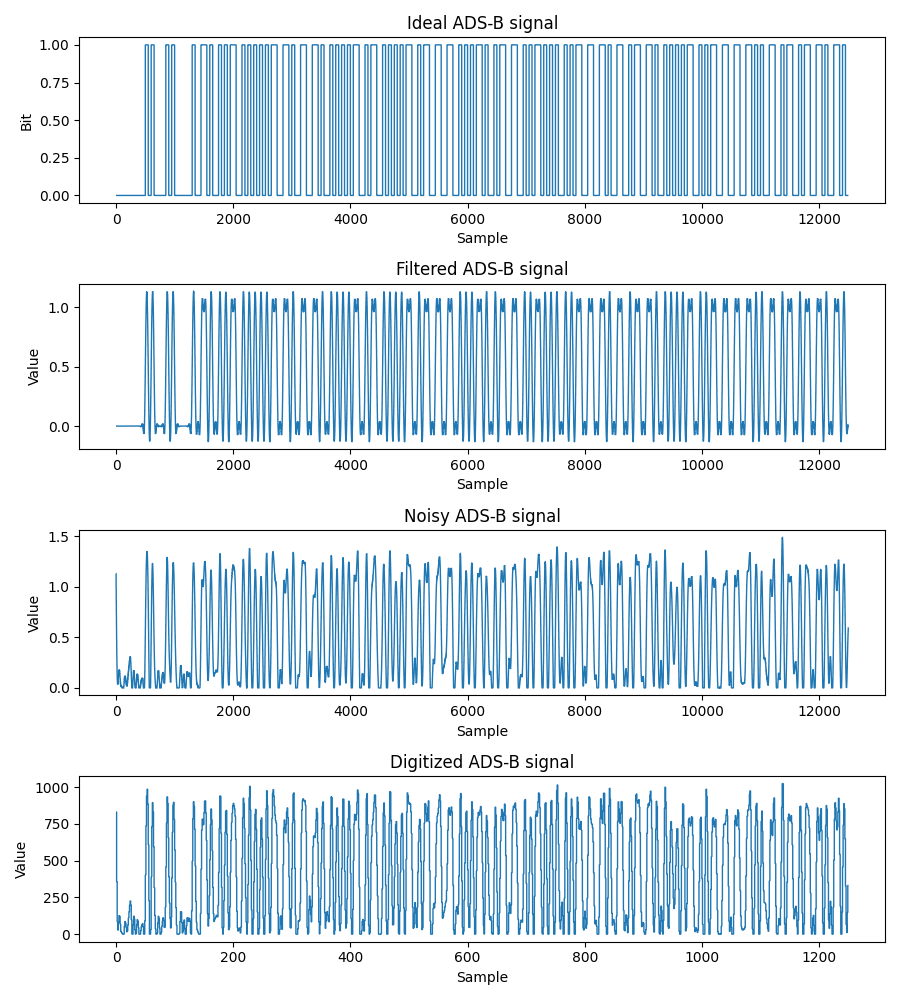

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from Functions.signal_generator import signal_start_pause_length, generate_ADSB, generate_ADSB_multiple, \
                                        digitize_signal, get_signal_energy, normalize_signal, \
                                        get_last_generated_signal_length, generate_approx, t_prescaler
from Functions.crc import generate_adsb_crc
from preambules_list import preambule_list, Preambule
from Functions.preambule_variant import Correlation
from Functions.utils import SAMPLE_ADSB_BYTES

#Configuration
amplitude = 1

#Generate and plot simulated ADS-B
ideal_signal, filtered_signal, noisy_signal = generate_ADSB(amplitude, SAMPLE_ADSB_BYTES)
#Digitize signal
digitized_signal, digitized_t = digitize_signal(noisy_signal, 100E6, 10E6, 1.4, 2**10)

plt.figure(figsize=(9,10))
plt.subplot(4, 1, 1)
plt.stairs(ideal_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Bit')
plt.title('Ideal ADS-B signal')

plt.subplot(4, 1, 2)
plt.stairs(filtered_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Filtered ADS-B signal')

plt.subplot(4, 1, 3)
plt.stairs(noisy_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Noisy ADS-B signal')

plt.subplot(4, 1, 4)
plt.stairs(digitized_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Digitized ADS-B signal')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

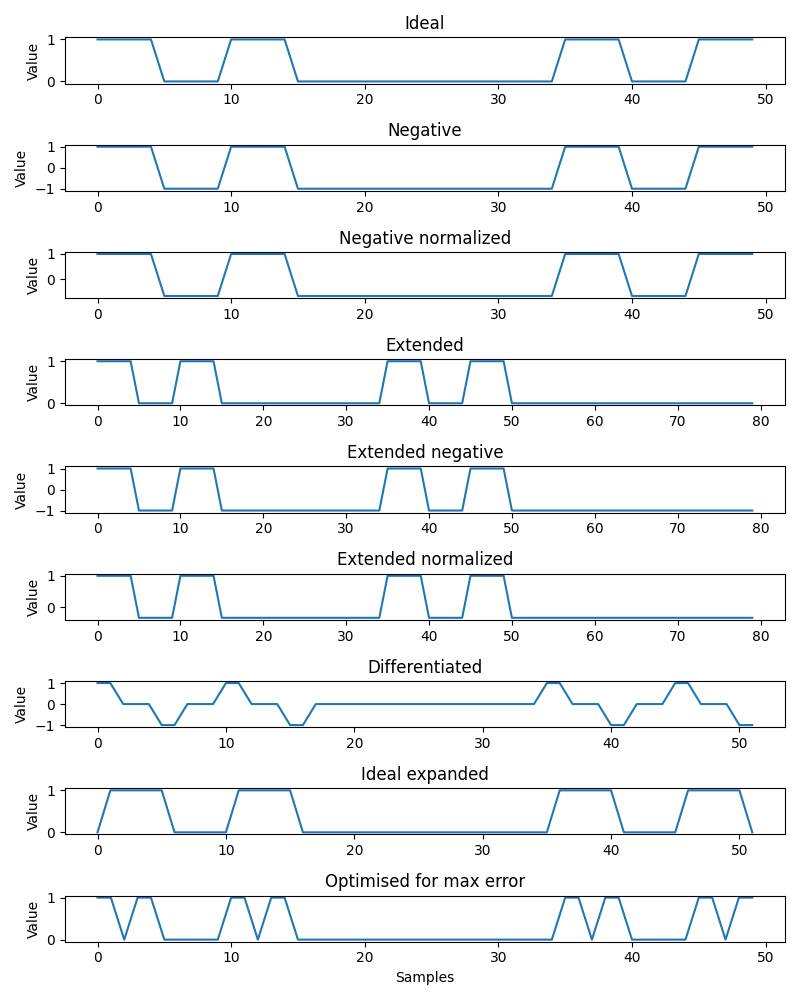

In [2]:
# Display all preambles
plt.figure(figsize=(8,10))
for i in range(Preambule.Last.value):
    preamble = preambule_list[i]
    plt.subplot(len(preambule_list), 1, i + 1)
    plt.plot(preamble.get_coefficients())
    plt.title(preamble.get_name())
    plt.ylabel("Value")
plt.xlabel("Samples")
plt.tight_layout()
plt.show()

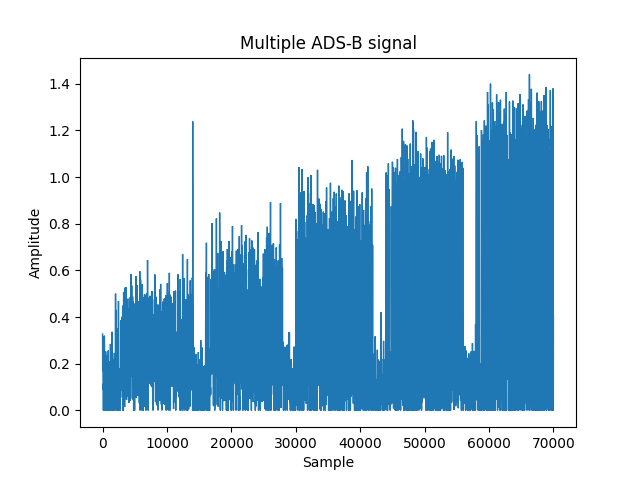

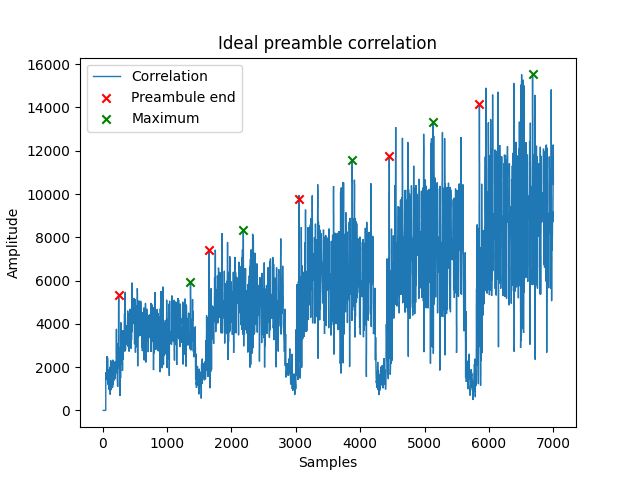

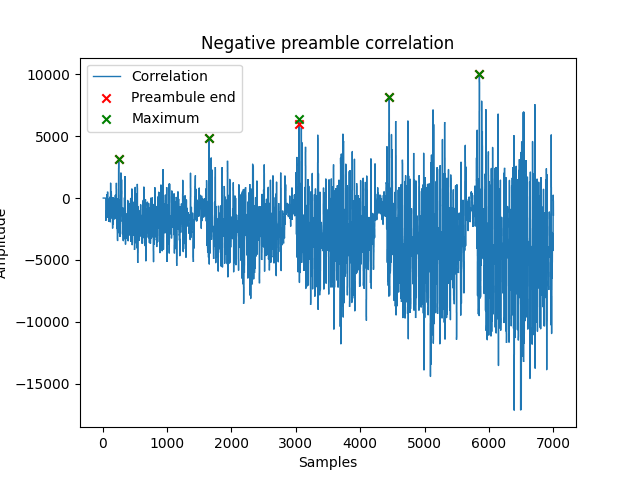

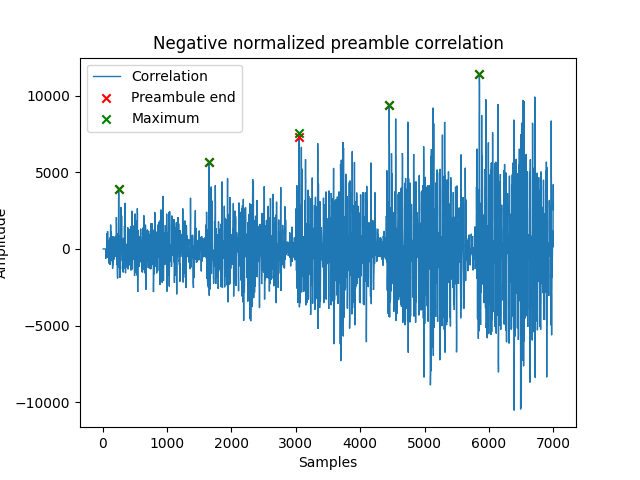

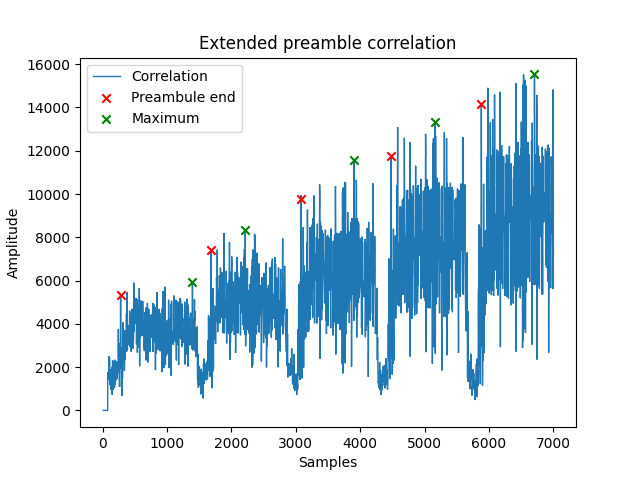

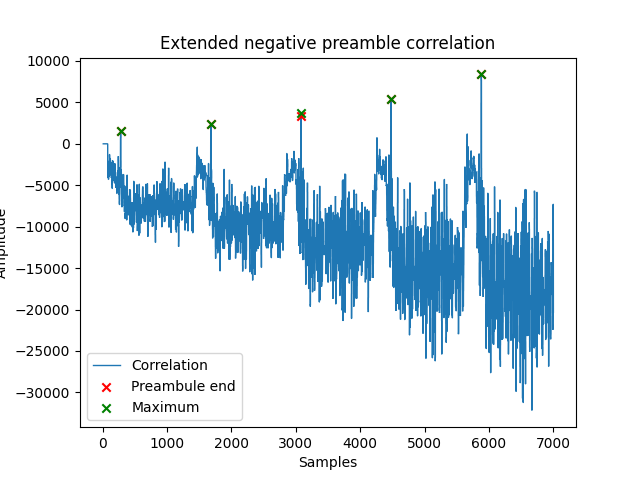

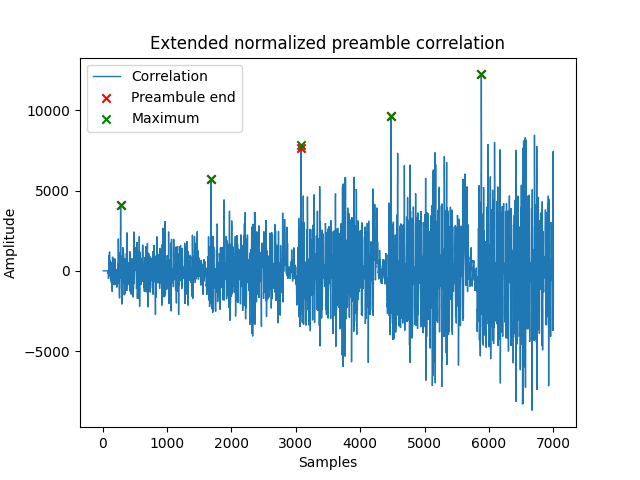

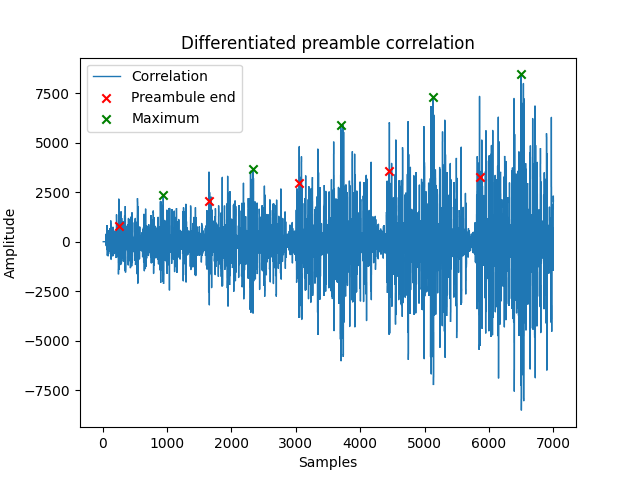

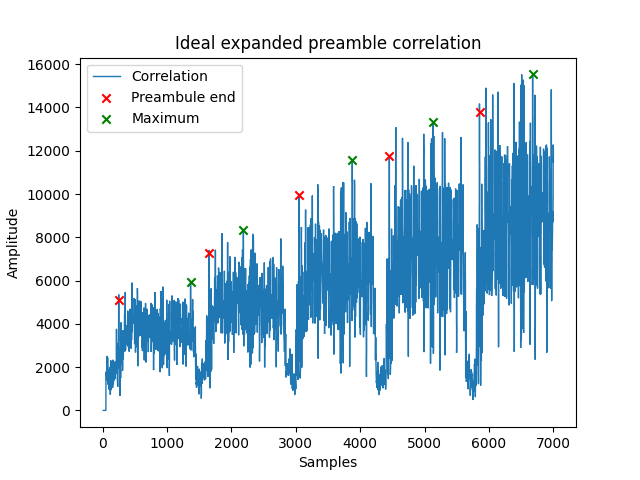

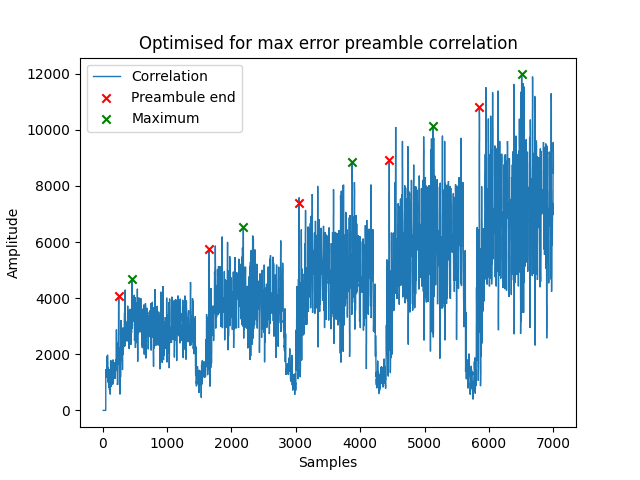

In [3]:
#Multiple signals
#Generate and plot simulated ADS-B
multiple_signal_gaps = 200
signal_amount = 5
multiple_amplitudes = np.linspace(0.3, 1, signal_amount)

full_multiple_signal, _ = generate_ADSB_multiple(multiple_amplitudes, SAMPLE_ADSB_BYTES)
one_signal_length = int(get_last_generated_signal_length()/t_prescaler)

plt.figure()
plt.stairs(full_multiple_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Multiple ADS-B signal')
plt.show()

full_multiple_signal_digitized, digitized_t = digitize_signal(full_multiple_signal, 100E6, 10E6, 1.4, 2**10)

for preambule in preambule_list:
    curr_preambule_corr = preambule.get_correlation(full_multiple_signal_digitized, Correlation.Basic)
    max_idxs = np.zeros(signal_amount)
    max_values = np.zeros(signal_amount)
    preambule_ends = np.zeros(signal_amount)
    preambule_ends_values = np.zeros(signal_amount)
    for i in range(signal_amount):
        max_idxs[i] = np.argmax(curr_preambule_corr[i*one_signal_length : i*one_signal_length + one_signal_length]) + i * one_signal_length
        max_values[i] = curr_preambule_corr[int(max_idxs[i])]
        preambule_ends[i] = multiple_signal_gaps + preambule.get_expected_maximum() + i * one_signal_length
        preambule_ends_values[i] = curr_preambule_corr[int(preambule_ends[i])]
    plt.figure()
    plt.stairs(curr_preambule_corr, label="Correlation", baseline=None)
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.title(preambule.get_name() + " preamble correlation")
    plt.scatter(preambule_ends, preambule_ends_values,
                marker='x', color='red', label="Preambule end")
    plt.scatter(max_idxs, max_values, marker='x', color='green', label="Maximum")
    plt.legend()
    plt.show()
